In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import keras
import datetime
from tensorflow.python.keras.callbacks import TensorBoard
from tensorflow.python.keras.layers.core import Dense, Activation, Dropout
from tensorflow.python.keras.layers.recurrent import LSTM
from tensorflow.python.keras.models import Sequential
import time #helper libraries

# Install the package for running tensorboard on google colaboration
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False
if IN_COLAB == True:
    from tensorboardcolab import *
    !pip install -U tensorboardcolab
    !pip install -q tf-nightly-2.0-preview
# Load the TensorBoard notebook extension
    %load_ext tensorboard
    from tensorboardcolab import *

Using TensorFlow backend.


## Step 1: Load the Data

Here we are going to load the data. To do this we will be creating windows of size 50.  This means that we will be creating sequences of size 50 from the input data as our training examples.

We are also going to normalize the data within each window. This is because the long-term direction of the market will ultimately change (we hope it will get higher), and we want the magnitude to be apples-to-apples across windows.

In [2]:
# Run this cell if you need to get the data

!wget https://s3.amazonaws.com/elephantscale-public/data/stocks/sp500.csv



'wget' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
#Step 1 Load Data
def normalise_windows(window_data):
    normalised_data = []
    for window in window_data:
        normalised_window = [((float(p) / float(window[0])) - 1) for p in window]
        normalised_data.append(normalised_window)
    return normalised_data


def load_data(filename, seq_len, normalise_window):
    f = open(filename, 'r').read()
    data = f.split('\n')

    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    
    if normalise_window:
        result = normalise_windows(result)

    result = np.array(result)

    row = round(0.9 * result.shape[0])
    train = result[:int(row), :]
    np.random.shuffle(train)
    x_train = train[:, :-1]
    y_train = train[:, -1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))  

    return [x_train, y_train, x_test, y_test]


URL = '/tmp/sp500.csv'
X_train, y_train, X_test, y_test = load_data(URL, 50, True)

## Step 2: Build the model

Let's build the model.  We have two LSTM layers of size 50 and 100, respectively.

`return_sequences` means that we will pass the hidden state of the LSTM to the next layer. This is required if we are going to have a stacked series of LSTM layers, as we are doing in this case.

The final layer is a dense (fully-connected) layer, with an output of 1. This is because we are ultimately trying to predict the next value in the stock market (a regression problem). We use `linear` activation because this is a regression problem and we are trying to get a real number output.


In [3]:
#Step 2 Build Model
model = Sequential()

model.add(LSTM(
    input_shape=(None,1),
    units=50,
    return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
    100,
    return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(
    units=1))
model.add(Activation('linear'))

start = time.time()
model.compile(loss='mse', optimizer='rmsprop')
print('compilation time : ', time.time() - start)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
compilation time :  0.1525890827178955


## Train the Model

**=> TODO: Train the model for some number of epochs**

Don't run too long. Something less than 10 will finish quickly enough.


In [4]:
#Step 3 Train the model

if IN_COLAB == True:
    log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    model.fit(X_train,
              y_train,
              batch_size=512,
              epochs=???,
              validation_split=0.05,
              validation_data=(X_test, y_test),
              callbacks=[tensorboard_callback])
else:
    tensorboard = TensorBoard(log_dir='/tmp/tensorflow_logs/example', histogram_freq=1)
    model.fit(X_train,
         y_train,
         batch_size=512,
         epochs=???,
         validation_split=0.05,
         validation_data=(X_test, y_test),
         callbacks=[tensorboard])

Train on 3709 samples, validate on 412 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/10
3709/3709 [==============================] - 10s 3ms/sample - loss: 0.0024 - val_loss: 4.7646e-04
Epoch 2/10
3709/3709 [==============================] - 7s 2ms/sample - loss: 6.9605e-04 - val_loss: 3.7601e-04
Epoch 3/10
3709/3709 [==============================] - 7s 2ms/sample - loss: 7.3478e-04 - val_loss: 3.6406e-04
Epoch 4/10
3709/3709 [==============================] - 7s 2ms/sample - loss: 5.6075e-04 - val_loss: 6.1198e-04
Epoch 5/10
3709/3709 [==============================] - 7s 2ms/sample - loss: 6.3339e-04 - val_loss: 3.3820e-04
Epoch 6/10
3709/3709 [==============================] - 7s 2ms/sample - loss: 5.0643e-04 - val_loss: 4.2592e-04
Epoch 7/10
3709/3709 [==============================] - 6s 2ms/sample - loss: 4.8729e-04 - val_loss: 3.3774e-04
Epoch 8/10
3709/3709 [==============================] - 7s 2ms/sample - loss: 5.1495e-04 - val_loss: 2.4357e-04
Epoch 9/10
3

In [1]:
### Now we run the TensorBaord

In [ ]:
#Automatic loading of tensorboard in Colab
if IN_COLAB:
    %tensorboard --logdir logs/fit

#### Local:

Now run the following command on a bash

```bash
$ tensorboard --logdir=/tmp/tensorflow_logs
```
Then open the browser(Chrome) and insert this address

```bash
localhost:6006
```

In [6]:
#Step 4 - Make Predictions  By steps of 50, before advancing another 50 steps

def predict_sequences_multiple(model, data, window_size, prediction_len):
    #Predict sequence of 50 steps before shifting prediction run forward by 50 steps
    prediction_seqs = []
    for i in range(len(data)//prediction_len):
        curr_frame = data[i*int(prediction_len)]
        predicted = []
        for j in range(int(prediction_len)):
            predicted.append(model.predict(curr_frame[np.newaxis,:,:])[0,0])
            curr_frame = curr_frame[1:]
            curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
        prediction_seqs.append(predicted)
    return prediction_seqs


predictions = predict_sequences_multiple(model, X_test, 50, 50)


## Step 5: Plot the Predictions

See the results.  The results here show a series of validation, seeing if we had trained the model up to a point, and then predicting *from* that point.  

The results here won't be very accurate, so definitely don't **trade** on this model!  The goal is to see if the model got the general sense of the direction of the market **from that point**.   There will be some hits and misses here; that is to be expected.

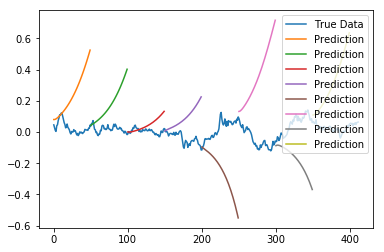

In [7]:
# Step 5 -- Plot predictions
def plot_results_multiple(predicted_data, true_data, prediction_len):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    #Pad the list of predictions to shift it in the graph to it's correct start
    for i, data in enumerate(predicted_data):
        padding = [None for p in range(i * prediction_len)]
        plt.plot(padding + data, label='Prediction')
        plt.legend()
    plt.show()

plot_results_multiple(predictions, y_test, 50)